In [1]:
%load_ext autoreload
%autoreload 2

import os
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_and_optimize_and_sample_petri_model,
    load_and_calibrate_and_optimize_and_sample_petri_model,
    get_posterior_density_mesh_petri,
    get_posterior_density_petri
)
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyciemss.visuals import plots

In [2]:
DEMO_PATH = "."
ASKENET_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/main/petrinet/examples/sir_typed.json"


## load_and_sample_petri_model

In [3]:
num_samples = 3
timepoints = [0.5, 1.0, 2.0, 3.0, 4.0]

# Run sampling w/o an intervention
result = load_and_sample_petri_model(ASKENET_PATH, num_samples, timepoints=timepoints, time_unit="days")

# Save results
result["data"].to_csv(os.path.join(DEMO_PATH, "results_petri/sample_results.csv"), index=False)
result["quantiles"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/quantiles_results.csv"), index=False
)

In [4]:
result["data"]

,timepoint_id,sample_id,beta_param,gamma_param,I_sol,R_sol,S_sol,timepoint_days
0,0,0,0.027433,0.160051,960.951111,38.742466,1.306471e+00,0.5
1,1,0,0.027433,0.160051,888.260498,112.739388,4.054480e-06,1.0
2,2,0,0.027433,0.160051,756.887451,244.112381,-4.604560e-10,2.0
3,3,0,0.027433,0.160051,644.944580,356.055573,-1.320352e-10,3.0
4,4,0,0.027433,0.160051,549.557800,451.442383,1.401467e-10,4.0
5,0,1,0.026378,0.162603,961.059509,37.751102,2.189583e+00,0.5
6,1,1,0.026378,0.162603,888.047546,112.952568,1.102242e-05,1.0
7,2,1,0.026378,0.162603,754.777161,246.223068,-2.741659e-10,2.0
8,3,1,0.026378,0.162603,641.506653,359.493530,-6.880185e-11,3.0
9,4,1,0.026378,0.162603,545.234741,455.765289,-1.176490e-09,4.0


In [5]:
result["quantiles"]

,timepoint_id,number_days,inc_cum,output,type,quantile,value,Forecast_Backcast
0,0,0.5,inc,I,quantile,0.010,9.609533e+02,Forecast
1,0,0.5,inc,I,quantile,0.025,9.609565e+02,Forecast
2,0,0.5,inc,I,quantile,0.050,9.609620e+02,Forecast
3,0,0.5,inc,I,quantile,0.100,9.609728e+02,Forecast
4,0,0.5,inc,I,quantile,0.150,9.609836e+02,Forecast
...,...,...,...,...,...,...,...,...
340,4,4.0,inc,S,quantile,0.850,5.579053e-10,Forecast
341,4,4.0,inc,S,quantile,0.900,6.175851e-10,Forecast
342,4,4.0,inc,S,quantile,0.950,6.772649e-10,Forecast
343,4,4.0,inc,S,quantile,0.975,7.071048e-10,Forecast


In [6]:
result["risk"]

{'I_sol': {'risk': [644.4429931640625],
  'qoi': array([597.2512, 593.3707, 644.443 ], dtype=float32)},
 'R_sol': {'risk': [407.62939453125],
  'qoi': array([403.74896, 407.6294 , 356.55573], dtype=float32)},
 'S_sol': {'risk': [1.9321966249208344e-10],
  'qoi': array([ 4.0557488e-12, -6.2264605e-10,  1.9321966e-10], dtype=float32)}}

## load_and_sample_petri_modelwith interventions

In [7]:
interventions = [(1.1, "beta", 1.0), (2.1, "gamma", 0.1), (1.3, "beta", 2.0), (1.4, "gamma", 0.3)]

result_int = load_and_sample_petri_model(
    ASKENET_PATH, num_samples, timepoints=timepoints, interventions=interventions,
    time_unit="days",
    visual_options={"title": "SIR Model", "keep": ".*_sol"}
)

# Save results
result_int["data"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/sample_results_w_interventions.csv"),
    index=False,
)
result_int["quantiles"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/quantiles_results_w_interventions.csv"), index=False
)

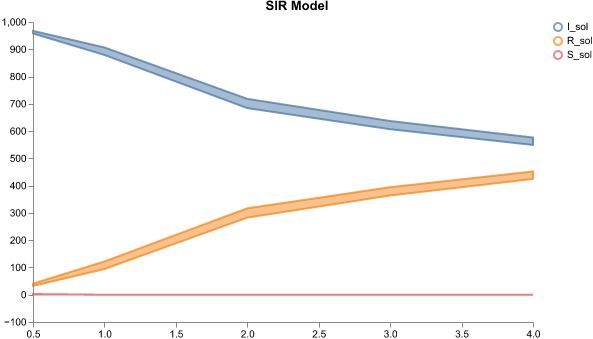

In [8]:
plots.ipy_display(result_int["visual"])

## load_and_calibrate_and_sample_petri_model

In [9]:
data_path = os.path.join(DEMO_PATH, "data.csv")
num_samples = 10
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]

# Run the calibration and sampling
result_cal = load_and_calibrate_and_sample_petri_model(
    ASKENET_PATH,
    data_path,
    num_samples,
    timepoints=timepoints,
    verbose=True,
    visual_options={"title": "Intervened SIR Model", "keep":".*_sol"},
    num_iterations=100,
    time_unit = "days"
)

# Save results
result_cal['data'].to_csv(
    os.path.join(DEMO_PATH, "results_petri/calibrated_sample_results.csv"), index=False
)
result_cal["quantiles"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/calibrated_quantiles_results.csv"), index=False
)

iteration 0: loss = 62.84040379524231
iteration 25: loss = 62.899396896362305
iteration 50: loss = 60.9055962562561
iteration 75: loss = 59.837971806526184


In [10]:
result_cal["data"].head()

,timepoint_id,sample_id,beta_param,gamma_param,I_sol,R_sol,S_sol,timepoint_days
0,0,0,0.026841,0.143077,1.000000,1.430772e-11,1.000000e+03,0.0
1,1,0,0.026841,0.143077,900.286133,1.007136e+02,6.231709e-06,1.0
2,2,0,0.026841,0.143077,780.266968,2.207335e+02,7.132712e-10,2.0
3,3,0,0.026841,0.143077,676.246826,3.247525e+02,6.123377e-10,3.0
4,4,0,0.026841,0.143077,586.094482,4.149052e+02,4.363533e-10,4.0


In [11]:
result_cal["quantiles"]

,timepoint_id,number_days,inc_cum,output,type,quantile,value,Forecast_Backcast
0,0,0.0,inc,I,quantile,0.010,1.000000e+00,Backcast
1,0,0.0,inc,I,quantile,0.025,1.000000e+00,Backcast
2,0,0.0,inc,I,quantile,0.050,1.000000e+00,Backcast
3,0,0.0,inc,I,quantile,0.100,1.000000e+00,Backcast
4,0,0.0,inc,I,quantile,0.150,1.000000e+00,Backcast
...,...,...,...,...,...,...,...,...
340,4,4.0,inc,S,quantile,0.850,8.714651e-10,Forecast
341,4,4.0,inc,S,quantile,0.900,8.882568e-10,Forecast
342,4,4.0,inc,S,quantile,0.950,9.223183e-10,Forecast
343,4,4.0,inc,S,quantile,0.975,9.393491e-10,Forecast


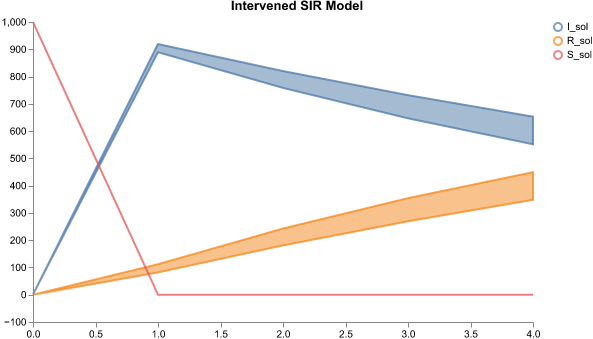

In [12]:
plots.ipy_display(result_cal["visual"])

Text(0, 0.5, 'gamma')

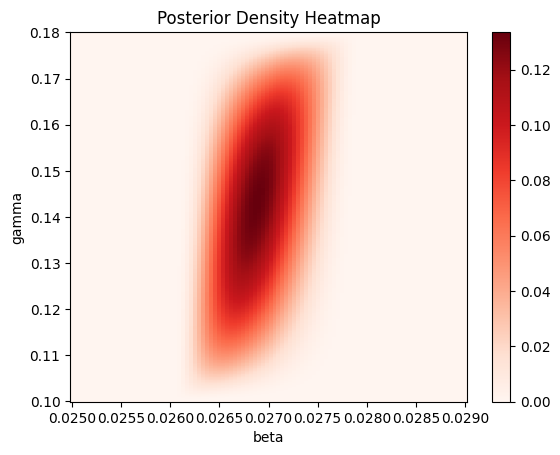

In [21]:
inferred_parameters = result_cal["inferred_parameters"]

params, density = get_posterior_density_mesh_petri(inferred_parameters=inferred_parameters, 
                                                   mesh_params={"beta": (0.025, 0.029, 100), 
                                                             "gamma": (0.1, 0.18, 500)})

fig, ax = plt.subplots()
c = ax.pcolormesh(params["beta"], params["gamma"], density, cmap='Reds')
ax.set_title('Posterior Density Heatmap')
fig.colorbar(c, ax=ax)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')

## load_and_optimize_and_sample_petri_model

In [ ]:
num_samples = 100
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]
OBJFUN = lambda x: np.abs(x)
INTERVENTION = [(0.1, "beta")]
QOI = ("scenario2dec_nday_average", "I_sol", 2)
# Run the optimization and sampling
result = load_and_optimize_and_sample_petri_model(
    ASKENET_PATH,
    num_samples,
    timepoints=timepoints,
    interventions=INTERVENTION,
    qoi=QOI,
    risk_bound=10.,
    objfun=OBJFUN,
    initial_guess=0.02,
    bounds=[[0.],[3.]],
    verbose=True,
)

ouu_samples = result["data"]
opt_policy = result["policy"]
# Save results
ouu_samples.to_csv(
    os.path.join(DEMO_PATH, "results_petri/optimize_sample_results.csv"), index=False
)
print("Optimal policy:", opt_policy["policy"])
print("Estimated risk at optimal policy", opt_policy["risk"])

## load_and_calibrate_and_optimize_and_sample_petri_model

In [ ]:
data_path = os.path.join(DEMO_PATH, "data.csv")
num_samples = 100
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]
OBJFUN = lambda x: np.abs(x)
INTERVENTION = [(0.1, "beta")]
QOI = ("scenario2dec_nday_average", "I_sol", 2)
# Run the calibration, optimization, and sampling
result = load_and_calibrate_and_optimize_and_sample_petri_model(
    ASKENET_PATH,
    data_path,
    num_samples,
    timepoints=timepoints,
    interventions=INTERVENTION,
    qoi=QOI,
    risk_bound=10.,
    objfun=OBJFUN,
    initial_guess=0.02,
    bounds=[[0.],[3.]],
    verbose=True,
)

ouu_cal_samples = result["data"]
opt_cal_policy = result["policy"]
# Save results
ouu_cal_samples.to_csv(
    os.path.join(DEMO_PATH, "results_petri/calibrate_optimize_sample_results.csv"), index=False
)
print("Optimal policy after calibration:", opt_policy["policy"])
print("Estimated risk at optimal policy after calibration", opt_policy["risk"])